In [ ]:
!pip install torchtext

     |████████████████████████████████| 2.0 MB 2.5 MB/s 
     |██████████▎                     | 1.5 MB 11.1 MB/

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 4.7 MB 11.1 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-413bdd92-2484-4c61-a2e7-73b4647696cc/bin/python -m pip install --upgrade pip' command.


In [ ]:
# supresses future warnings 
import warnings                                                 
warnings.simplefilter(action='ignore')

# Import the pandas library for df creation
import pandas as pd

# Import the NumPy library to use the random package
import numpy as np
import math

# Import the matplotlib library for plotting
import matplotlib.pyplot as plt

# set plot style
plt.style.use('seaborn-whitegrid')

# Use the magic function to ensure plots render in a notebook
%matplotlib inline

# Import the seaborn library for plotting
import seaborn as sns

from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, precision_recall_curve, auc

from datetime import datetime

# from shutil import copyfile

import pickle

import shutil

import datetime

from datetime import timedelta

from datetime import datetime

import plotly.express as px

import scipy.stats as ss

import warnings

# from causalnex.structure import StructureModel

warnings.simplefilter(action='ignore')

from pyspark.sql.functions import date_format

from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import MiniBatchKMeans

from transformers import pipeline
import torch
import torch.nn.functional as F
import torchtext
import time
import gzip
import transformers
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification

---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
File <command-2780909012421510>:65
     63 import torch
     64 import torch.nn.functional as F
---> 65 import torchtext
     66 import time
     67 import gzip

File /databricks/python_shell/dbruntime/PythonPackageImportsInstrumentation/__init__.py:171, in _create_import_patch.<locals>.import_patch(name, globals, locals, fromlist, level)
    166 thread_local._nest_level += 1
    168 try:
    169     # Import the desired module. If you’re seeing this while debugging a failed import,
    170     # look at preceding stack frames for relevant error information.
--> 171     original_result = python_builtin_import(name, globals, locals, fromlist, level)
    173     is_root_import = thread_local._nest_level == 1
    174     # `level` represents the number of leading dots in a relative import statement.
    175     # If it's zero, then this is

In [ ]:
torch.backends.cudnn.deterministic = True
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NUM_EPOCHS = 3
DEVICE

Out[3]: device(type='cpu')

In [ ]:
df_lead["CLOSD_STS"].value_counts()

Out[24]: Closed - No Sale    389301
Closed - Sale        77008
Name: CLOSD_STS, dtype: int64

In [ ]:
df_lead.shape, df_val.shape, df_test.shape

Out[8]: ((466463, 16), (106179, 16), (76717, 16))

In [ ]:
# Filters for our data
df_lead = df_lead[df_lead["STS"] == "Closed"]
df_lead = df_lead[df_lead["RSN_FOR_LEAVING"] == "Sales Opportunity"]

df_lead.drop(["LEAD_SRC", "STS", "RSN_FOR_LEAVING"], axis=1, inplace=True)

In [ ]:
# Filters for our data
df_val = df_val[df_val["STS"] == "Closed"]
df_val = df_val[df_val["RSN_FOR_LEAVING"] == "Sales Opportunity"]

df_val.drop(["LEAD_SRC", "STS", "RSN_FOR_LEAVING"], axis=1, inplace=True)

In [ ]:
# Filters for our data
df_test = df_test[df_test["STS"] == "Closed"]
df_test = df_test[df_test["RSN_FOR_LEAVING"] == "Sales Opportunity"]

df_test.drop(["LEAD_SRC", "STS", "RSN_FOR_LEAVING"], axis=1, inplace=True)


## All Preprocessing steps

In [ ]:
# # Filters for our data
# df_lead = df_lead[df_lead["STS"] == "Closed"]
# df_lead = df_lead[df_lead["RSN_FOR_LEAVING"] == "Sales Opportunity"]

# Feature Engineering on Date Columns
df_lead["Days_diff"] = (pd.to_datetime(df_lead['EXPIRY_DT']) - pd.to_datetime(df_lead.CREATED_DT)).apply(lambda x: x.days)
df_lead['dt_day_of_week'] = (pd.to_datetime(df_lead['CREATED_DT'])).apply(lambda x: x.day_of_week)

# Calculating the length of text for 1st iteration
df_lead["text_len"] = df_lead["OTH_NOTE"].apply(lambda x: 0 if type(x)==float else len(x))


# Transforming TRANS_TYPE column

df_lead['Other_t'] = df_lead['TRANS'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Other' in x))
df_lead['Add_a'] = df_lead['TRANS'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Add-a-Line' in x))
df_lead['Upgra'] = df_lead['TRANS'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Upgrade' in x))
df_lead['Rate'] = df_lead['TRANS'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Rate Plan Migration' in x))

# Transforming PRD_DSCSD column

df_lead['Wireless'] = df_lead['PRD_DSCSD'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Wireless' in x))
df_lead['Internet'] = df_lead['PRD_DSCSD'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Internet' in x))
df_lead['Video'] = df_lead['PRD_DSCSD'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Video' in x))


# Transforming PREF_MTHD_OF_CONTCT column

df_lead['In Person'] = df_lead['PREF_MTHD_OF_CONTCT'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('In Person' in x))
df_lead['Email'] = df_lead['PREF_MTHD_OF_CONTCT'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Email' in x))
df_lead['SMS'] = df_lead['PREF_MTHD_OF_CONTCT'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('SMS' in x))
df_lead['Call'] = df_lead['PREF_MTHD_OF_CONTCT'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Call' in x))


# Preprocessing for Loc_type keeping top 6 values rest as others
def Loc_type(x):
  if x == "STORE-ARC":
    return "STORE-ARC"
  elif x == "STORE":
    return "STORE"
  elif x == "IN-HOME EXPERTS":
    return "IN-HOME EXPERTS"
  elif x == "VIRTUAL SALES EXP":
    return "VIRTUAL SALES EXP"
  elif x == "MOBILE EVENTS":
    return "MOBILE EVENTS"
  elif x == "KIOSK-ARC":
    return "KIOSK-ARC"
  else :
    return "Other_Loc"

df_lead["LOC_TYPE"] = df_lead["LOC_TYPE"].apply(lambda x : Loc_type(x))

# RTG preprocess

def priority(x):
  if x == "Priority":
    return 1
  else :
    return 0
  
df_lead["RTG"] = df_lead["RTG"].apply(lambda x: priority(x))



# CUST_TYPE preprocess

def Cust_type(x):
  if x == "Existing Customer":
    return 0
  else :
    return 1
  
df_lead["CUST_TYPE"] = df_lead["CUST_TYPE"].apply(lambda x : Cust_type(x))


# Target Variable Encoding

def tar_var(x):
  if x == "Closed - Sale": 
    return 1
  else:
    return 0
  
df_lead["CLOSD_STS"] = df_lead["CLOSD_STS"].apply(lambda x: tar_var(x))

# Handling -ve values in Days_Diff

def days_diff(x):
  if x < 0: 
    return 0
  else:
    return x

df_lead["Days_diff"] = df_lead["Days_diff"].apply(lambda x: days_diff(x))


# Imputing missing values

df_lead["PREV_CARR"] = df_lead[df_lead["CUST_TYPE"] == 0]["PREV_CARR"].fillna("Existing")
df_lead["PREV_CARR"] = df_lead["PREV_CARR"].fillna("Unknown")

df_lead["SLS_OPRT"] = df_lead["SLS_OPRT"].fillna(df_lead["SLS_OPRT"].mode()[0])

# df_lead["SLS_OPRT"] = df_lead["SLS_OPRT"].fillna(df_lead["SLS_OPRT"].mode()[0])
 
df_lead["NBR_ADDL_LNS"] = df_lead["NBR_ADDL_LNS"].fillna(0)

# One hot encode columns

df_lead = pd.get_dummies(df_lead, columns=["PREV_CARR", "LOC_TYPE", "SLS_OPRT"]) #  drop_first=True,

df_lead = df_lead.drop(["EXPIRY_DT", "CREATED_DT", "TRANS_TYPE", "PRD_DSCSD","PREF_MTHD_OF_CONTCT"], axis=1) #"RSN_FOR_LEAVING", "STS", 

In [ ]:
# # Filters for our data
# df_lead = df_lead[df_lead["STS"] == "Closed"]
# df_lead = df_lead[df_lead["RSN_FOR_LEAVING"] == "Sales Opportunity"]

# Feature Engineering on Date Columns
df_val["Days_diff"] = (pd.to_datetime(df_val['EXPIRY_DT']) - pd.to_datetime(df_val.CREATED_DT)).apply(lambda x: x.days)
df_val['dt_day_of_week'] = (pd.to_datetime(df_val['CREATED_DT'])).apply(lambda x: x.day_of_week)

# Calculating the length of text for 1st iteration
df_val["text_len"] = df_val["OTH_NOTE"].apply(lambda x: 0 if type(x)==float else len(x))


# Transforming TRANS_TYPE column

df_val['Other_Trans_Type'] = df_val['TRANS_TYPE'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Other' in x))
df_val['Add_a_Line'] = df_val['TRANS_TYPE'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Add-a-Line' in x))
df_val['Upgrade'] = df_val['TRANS_TYPE'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Upgrade' in x))
df_val['Rate_Plan_Migration'] = df_val['TRANS_TYPE'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Rate Plan Migration' in x))

# Transforming PRD_DSCSD column

df_val['Wireless'] = df_val['PRD_DSCSD'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Wireless' in x))
df_val['Internet'] = df_val['PRD_DSCSD'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Internet' in x))
df_val['Video'] = df_val['PRD_DSCSD'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Video' in x))


# Transforming PREF_MTHD_OF_CONTCT column

df_val['In Person'] = df_val['PREF_MTHD_OF_CONTCT'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('In Person' in x))
df_val['Email'] = df_val['PREF_MTHD_OF_CONTCT'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Email' in x))
df_val['SMS'] = df_val['PREF_MTHD_OF_CONTCT'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('SMS' in x))
df_val['Call'] = df_val['PREF_MTHD_OF_CONTCT'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Call' in x))


# Preprocessing for Loc_type keeping top 6 values rest as others
def Loc_type(x):
  if x == "STORE-ARC":
    return "STORE-ARC"
  elif x == "STORE":
    return "STORE"
  elif x == "IN-HOME EXPERTS":
    return "IN-HOME EXPERTS"
  elif x == "VIRTUAL SALES EXP":
    return "VIRTUAL SALES EXP"
  elif x == "MOBILE EVENTS":
    return "MOBILE EVENTS"
  elif x == "KIOSK-ARC":
    return "KIOSK-ARC"
  else :
    return "Other_Loc"

df_val["LOC_TYPE"] = df_val["LOC_TYPE"].apply(lambda x : Loc_type(x))

# RTG preprocess

def priority(x):
  if x == "Priority":
    return 1
  else :
    return 0
  
df_val["RTG"] = df_val["RTG"].apply(lambda x: priority(x))



# CUST_TYPE preprocess

def Cust_type(x):
  if x == "Existing Customer":
    return 0
  else :
    return 1
  
df_val["CUST_TYPE"] = df_val["CUST_TYPE"].apply(lambda x : Cust_type(x))


# Target Variable Encoding

def tar_var(x):
  if x == "Closed - Sale": 
    return 1
  else:
    return 0
  
df_val["CLOSD_STS"] = df_val["CLOSD_STS"].apply(lambda x: tar_var(x))

# Handling -ve values in Days_Diff

def days_diff(x):
  if x < 0: 
    return 0
  else:
    return x

df_val["Days_diff"] = df_val["Days_diff"].apply(lambda x: days_diff(x))


# Imputing missing values

df_val["PREV_CARR"] = df_val[df_val["CUST_TYPE"] == 0]["PREV_CARR"].fillna("Existing")
df_val["PREV_CARR"] = df_val["PREV_CARR"].fillna("Unknown")

df_val["SLS_OPRT"] = df_val["SLS_OPRT"].fillna(df_val["SLS_OPRT"].mode()[0])

# df_lead["SLS_OPRT"] = df_lead["SLS_OPRT"].fillna(df_lead["SLS_OPRT"].mode()[0])
 
df_val["NBR_ADDL_LNS"] = df_val["NBR_ADDL_LNS"].fillna(0)

# One hot encode columns

df_val = pd.get_dummies(df_val, columns=["PREV_CARR", "LOC_TYPE", "SLS_OPRT"]) #  drop_first=True,

df_val = df_val.drop(["EXPIRY_DT", "CREATED_DT", "TRANS_TYPE", "PRD_DSCSD","PREF_MTHD_OF_CONTCT"], axis=1) #"RSN_FOR_LEAVING", "STS", 

In [ ]:
# # Filters for our data
# df_test = df_test[df_test["STS"] == "Closed"]
# df_test = df_test[df_test["RSN_FOR_LEAVING"] == "Sales Opportunity"]

# Feature Engineering on Date Columns
df_test["Days_diff"] = (pd.to_datetime(df_test['EXPIRY_DT']) - pd.to_datetime(df_test.CREATED_DT)).apply(lambda x: x.days)
df_test['dt_day_of_week'] = (pd.to_datetime(df_test['CREATED_DT'])).apply(lambda x: x.day_of_week)

# Calculating the length of text for 1st iteration
df_test["text_len"] = df_test["OTH_NOTE"].apply(lambda x: 0 if type(x)==float else len(x))


# Transforming TRANS_TYPE column

df_test['Other_Trans_Type'] = df_test['TRANS_TYPE'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Other' in x))
df_test['Add_a_Line'] = df_test['TRANS_TYPE'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Add-a-Line' in x))
df_test['Upgrade'] = df_test['TRANS_TYPE'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Upgrade' in x))
df_test['Rate_Plan_Migration'] = df_test['TRANS_TYPE'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Rate Plan Migration' in x))

# Transforming PRD_DSCSD column

df_test['Wireless'] = df_test['PRD_DSCSD'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Wireless' in x))
df_test['Internet'] = df_test['PRD_DSCSD'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Internet' in x))
df_test['Video'] = df_test['PRD_DSCSD'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Video' in x))


# Transforming PREF_MTHD_OF_CONTCT column

df_test['In Person'] = df_test['PREF_MTHD_OF_CONTCT'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('In Person' in x))
df_test['Email'] = df_test['PREF_MTHD_OF_CONTCT'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Email' in x))
df_test['SMS'] = df_test['PREF_MTHD_OF_CONTCT'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('SMS' in x))
df_test['Call'] = df_test['PREF_MTHD_OF_CONTCT'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Call' in x))


# Preprocessing for Loc_type keeping top 6 values rest as others
def Loc_type(x):
  if x == "STORE-ARC":
    return "STORE-ARC"
  elif x == "STORE":
    return "STORE"
  elif x == "IN-HOME EXPERTS":
    return "IN-HOME EXPERTS"
  elif x == "VIRTUAL SALES EXP":
    return "VIRTUAL SALES EXP"
  elif x == "MOBILE EVENTS":
    return "MOBILE EVENTS"
  elif x == "KIOSK-ARC":
    return "KIOSK-ARC"
  else :
    return "Other_Loc"

df_test["LOC_TYPE"] = df_test["LOC_TYPE"].apply(lambda x : Loc_type(x))

# RTG preprocess

def priority(x):
  if x == "Priority":
    return 1
  else :
    return 0
  
df_test["RTG"] = df_test["RTG"].apply(lambda x: priority(x))


# # Lead SRC preprocess

# def Lead_src(x):
#   if x == "Customer Interaction":
#     return 0
#   else :
#     return 1

# df_test["LEAD_SRC"] = df_test["LEAD_SRC"].apply(lambda x : Lead_src(x))

# CUST_TYPE preprocess

def Cust_type(x):
  if x == "Existing Customer":
    return 0
  else :
    return 1
  
df_test["CUST_TYPE"] = df_test["CUST_TYPE"].apply(lambda x : Cust_type(x))


# Target Variable Encoding

def tar_var(x):
  if x == "Closed - Sale": 
    return 1
  else:
    return 0
  
df_test["CLOSD_STS"] = df_test["CLOSD_STS"].apply(lambda x: tar_var(x))

# Handling -ve values in Days_Diff

def days_diff(x):
  if x < 0: 
    return 0
  else:
    return x

df_test["Days_diff"] = df_test["Days_diff"].apply(lambda x: days_diff(x))


# Imputing missing values

df_test["PREV_CARR"] = df_test[df_test["CUST_TYPE"] == 0]["PREV_CARR"].fillna("Existing")
df_test["PREV_CARR"] = df_test["PREV_CARR"].fillna("Unknown")

df_test["SLS_OPRT"] = df_test["SLS_OPRT"].fillna(df_test["SLS_OPRT"].mode()[0])

# df_lead["SLS_OPRT"] = df_lead["SLS_OPRT"].fillna(df_lead["SLS_OPRT"].mode()[0])
 
df_test["NBR_ADDL_LNS"] = df_test["NBR_ADDL_LNS"].fillna(0)

# One hot encode columns

df_test = pd.get_dummies(df_test, columns=["PREV_CARR", "LOC_TYPE", "SLS_OPRT"]) # drop_first=True,

df_test = df_test.drop(["EXPIRY_DT", "CREATED_DT", "TRANS_TYPE", "PRD_DSCSD","PREF_MTHD_OF_CONTCT"], axis=1) #"RSN_FOR_LEAVING", "STS", 

In [ ]:
df_lead.shape, df_val.shape, df_test.shape

Out[15]: ((343873, 33), (72018, 33), (76717, 32))

In [ ]:
# params = {'scale_pos_weight': 30}
# {'colsample_bytree': 0.9539991433318955, 'gamma': 0.527, 'learning_rate': 0.39808499710887085, 'max_depth': 15, 'min_child_weight': 1.0, 'scale_pos_weight': 50, 'subsample': 0.4000497558725}

In [ ]:
y_train = df_lead["CLOSD_STS"]
X_train = df_lead.drop(["CLOSD_STS"], axis=1)

Y = df_test["CLOSD_STS"]
X = df_test.drop(["CLOSD_STS"], axis=1)

X_val, X_test, y_val, y_test = train_test_split(X, Y, test_size=0.15, random_state=100, stratify=Y)

In [ ]:
y_train = df_lead["CLOSD_STS"]
X_train = df_lead.drop(["CLOSD_STS"], axis=1)

y_test = df_test["CLOSD_STS"]
X_test = df_test.drop(["CLOSD_STS"], axis=1)

y_val = df_val["CLOSD_STS"]
X_val = df_val.drop(["CLOSD_STS"], axis=1)

In [ ]:
# importing XGBOOST Classifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# train validation split of traing data
from sklearn.model_selection import train_test_split

y_train = df_lead["CLOSD_STS"]
X_train = df_lead.drop(["CLOSD_STS"], axis=1)

y_test = df_test["CLOSD_STS"]
X_test = df_test.drop(["CLOSD_STS"], axis=1)

y_val = df_val["CLOSD_STS"]
X_val = df_val.drop(["CLOSD_STS"], axis=1)

# X_val, X_test, y_val, y_test = train_test_split(X, Y, test_size=0.15, random_state=100, stratify=Y)

text_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
          min_df = 5,
        max_df = 0.95,
        max_features = 8000
        ,stop_words = 'english'
        )
        ),
        ('clf', MiniBatchKMeans(n_clusters=35, init_size=1024, batch_size=2048, random_state=20))
])
  
# X_train['clusters'] = text_pipeline.fit_predict(X_train['OTH_NOTE'])

X_train["clusters"] = -1

X_train["clusters"].loc[X_train['OTH_NOTE'].notna()] = text_pipeline.fit_predict(X_train['OTH_NOTE'].loc[X_train['OTH_NOTE'].notna()])

X_val["clusters"] = -1

X_val["clusters"].loc[X_val['OTH_NOTE'].notna()] = text_pipeline.predict(X_val['OTH_NOTE'].loc[X_val['OTH_NOTE'].notna()])

X_test["clusters"] = -1

X_test["clusters"].loc[X_test['OTH_NOTE'].notna()] = text_pipeline.predict(X_test['OTH_NOTE'].loc[X_test['OTH_NOTE'].notna()])


# Build/train Distilbert probability model for probability feature
leads_df = df_lead.copy()
leads_df['OTH_NOTE_Clean'] = leads_df.OTH_NOTE
leads_df.loc[leads_df.OTH_NOTE_Clean.notna(),'OTH_NOTE_Clean'] = leads_df.loc[leads_df.OTH_NOTE_Clean.notna()].OTH_NOTE_Clean.str.replace("[\<].*?[\>]", "")
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')


leads_df['labels'] = leads_df.CLOSD_STS
leads_df['text'] = leads_df.OTH_NOTE_Clean
leads_df = leads_df.loc[leads_df.text.notna(),['text','labels']]

import numpy as np
t1, t2 = int(np.ceil((35000)/50000*leads_df.shape[0])), int(np.ceil((35000)/50000*leads_df.shape[0])) +int(np.ceil((40_000-35000)/50000*leads_df.shape[0]))
# 70-20-10 split for train-validation-test

train_texts = leads_df.iloc[:t1]['text'].values
train_labels = leads_df.iloc[:t1]['labels'].values

valid_texts = leads_df.iloc[t1:t2]['text'].values
valid_labels = leads_df.iloc[t1:t2]['labels'].values

test_texts = leads_df.iloc[t2:]['text'].values
test_labels = leads_df.iloc[t2:]['labels'].values

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
valid_encodings = tokenizer(list(valid_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

class LeadsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = LeadsDataset(train_encodings, train_labels)
valid_dataset = LeadsDataset(valid_encodings, valid_labels)
test_dataset = LeadsDataset(test_encodings, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(DEVICE)
model.train()

optim = torch.optim.Adam(model.parameters(), lr=5e-5)

def compute_accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        
        for batch_idx, batch in enumerate(data_loader):
        
        ### Prepare data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            predicted_labels = torch.argmax(logits, 1)
            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()
        
        return correct_pred.float()/num_examples * 100
      
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, batch in enumerate(train_loader):
        
        ### Prepare data
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        ### Forward
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs['loss'], outputs['logits']
        
        ### Backward
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        ### Logging
        if not batch_idx % 250:
            print (f'Epoch: {epoch+1:04d}/{NUM_EPOCHS:04d} | '
                   f'Batch {batch_idx:04d}/{len(train_loader):04d} | '
                   f'Loss: {loss:.4f}')
            
    model.eval()

    with torch.set_grad_enabled(False):
        print(f'Training accuracy: '
              f'{compute_accuracy(model, train_loader, DEVICE):.2f}%'
              f'\nValid accuracy: '
              f'{compute_accuracy(model, valid_loader, DEVICE):.2f}%')
        
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')


def compute_preds(model, data_loader, device):
  with torch.no_grad():
      preds = []
      
      for batch_idx, batch in enumerate(data_loader):
      
      ### Prepare data
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)
          outputs = model(input_ids, attention_mask=attention_mask)
          # logits = outputs['logits']
          # predicted_labels = torch.argmax(logits, 1)
          # preds += predicted_labels
          # logits = outputs['logits']
          # predicted_labels = torch.argmax(logits, 1)
          preds += outputs['logits']            
      
      return preds


X_train["distil_preds"] = -1
X_val["distil_preds"] = -1
X_test["distil_preds"] = -1

X_train['text'] = X_train['OTH_NOTE']
X_train.loc[X_train.text.notna(),'text'] = X_train.loc[X_train.text.notna()].text.str.replace("[\<].*?[\>]", "")
X_train['labels'] = 0

X_val['text'] = X_val['OTH_NOTE']
X_val.loc[X_val.text.notna(),'text'] = X_val.loc[X_val.text.notna()].text.str.replace("[\<].*?[\>]", "")
X_val['labels'] = 0

X_test['text'] = X_test['OTH_NOTE']
X_test.loc[X_test.text.notna(),'text'] = X_test.loc[X_test.text.notna()].text.str.replace("[\<].*?[\>]", "")
X_test['labels'] = 0


train_texts = X_train["text"].loc[X_train['text'].notna()].values
train_labels = X_train["labels"].loc[X_train['text'].notna()].values

val_texts = X_val["text"].loc[X_val['text'].notna()].values
val_labels = X_val["labels"].loc[X_val['text'].notna()].values

test_texts = X_test["text"].loc[X_test['text'].notna()].values
test_labels = X_test["labels"].loc[X_test['text'].notna()].values


train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
train_dataset = LeadsDataset(train_encodings, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)


val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
val_dataset = LeadsDataset(val_encodings, val_labels)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)


test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)
test_dataset = LeadsDataset(test_encodings, test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

def second_term(lst):
  return np.exp(float(lst[1]))

s = pd.Series(compute_preds(model, train_loader, DEVICE))
X_train["distil_preds"].loc[X_train['OTH_NOTE'].notna()] = s.apply(second_term)

s = pd.Series(compute_preds(model, val_loader, DEVICE))
X_val["distil_preds"].loc[X_val['OTH_NOTE'].notna()] = s.apply(second_term)

s = pd.Series(compute_preds(model, test_loader, DEVICE))
X_test["distil_preds"].loc[X_test['OTH_NOTE'].notna()] = s.apply(second_term)




X_train.drop(["OTH_NOTE",'text','labels'], axis = 1, inplace = True)
X_val.drop(["OTH_NOTE",'text','labels'], axis = 1, inplace = True)
X_test.drop(["OTH_NOTE",'text','labels'], axis = 1, inplace = True)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7efacd980160>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callba

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 0001/0003 | Batch 0000/9190 | Loss: 0.7409
Epoch: 0001/0003 | Batch 0250/9190 | Loss: 0.3337
Epoch: 0001/0003 | Batch 0500/9190 | Loss: 0.4416
Epoch: 0001/0003 | Batch 0750/9190 | Loss: 0.1492
Epoch: 0001/0003 | Batch 1000/9190 | Loss: 0.2676
Epoch: 0001/0003 | Batch 1250/9190 | Loss: 0.4282
Epoch: 0001/0003 | Batch 1500/9190 | Loss: 0.9109
Epoch: 0001/0003 | Batch 1750/9190 | Loss: 0.1671
Epoch: 0001/0003 | Batch 2000/9190 | Loss: 0.4881
Epoch: 0001/0003 | Batch 2250/9190 | Loss: 0.3905
Epoch: 0001/0003 | Batch 2500/9190 | Loss: 0.6824
Epoch: 0001/0003 | Batch 2750/9190 | Loss: 0.4266
Epoch: 0001/0003 | Batch 3000/9190 | Loss: 0.17

In [ ]:
with open("/dbfs/FileStore/hj8398/Leads/transformer_model_current_25Nov2023.pickle", 'wb') as f:
  pickle.dump(model, f)

In [ ]:
X_train.columns

Out[20]: Index(['CUST_TYPE', 'NBR_ADDL_LNS', 'RTG', 'Days_diff', 'dt_day_of_week',
       'text_len', 'Other_Trans_Type', 'Add_a_Line', 'Upgrade',
       'Rate_Plan_Migration', 'Wireless', 'Internet', 'Video', 'In Person',
       'Email', 'SMS', 'Call', 'PREV_CARR_Existing', 'PREV_CARR_Unknown',
       'LOC_TYPE_IN-HOME EXPERTS', 'LOC_TYPE_KIOSK-ARC',
       'LOC_TYPE_MOBILE EVENTS', 'LOC_TYPE_Other_Loc', 'LOC_TYPE_STORE',
       'LOC_TYPE_STORE-ARC', 'LOC_TYPE_VIRTUAL SALES EXP', 'SLS_OPRT_Account',
       'SLS_OPRT_Consult Someone Else', 'SLS_OPRT_Price',
       'SLS_OPRT_Product (Out of Stock)', 'SLS_OPRT_Time', 'clusters',
       'distil_preds'],
      dtype='object')

In [ ]:
X_train['LOC_TYPE_MOBILE EVENTS'].value_counts()

Out[21]: 0    341328
1      2545
Name: LOC_TYPE_MOBILE EVENTS, dtype: int64

In [ ]:
X_val['LOC_TYPE_MOBILE EVENTS'] = 0
X_test['LOC_TYPE_MOBILE EVENTS'] = 0

In [ ]:
X_val.columns

Out[23]: Index(['CUST_TYPE', 'NBR_ADDL_LNS', 'RTG', 'Days_diff', 'dt_day_of_week',
       'text_len', 'Other_Trans_Type', 'Add_a_Line', 'Upgrade',
       'Rate_Plan_Migration', 'Wireless', 'Internet', 'Video', 'In Person',
       'Email', 'SMS', 'Call', 'PREV_CARR_Existing', 'PREV_CARR_Unknown',
       'LOC_TYPE_IN-HOME EXPERTS', 'LOC_TYPE_KIOSK-ARC',
       'LOC_TYPE_MOBILE EVENTS', 'LOC_TYPE_Other_Loc', 'LOC_TYPE_STORE',
       'LOC_TYPE_STORE-ARC', 'LOC_TYPE_VIRTUAL SALES EXP', 'SLS_OPRT_Account',
       'SLS_OPRT_Consult Someone Else', 'SLS_OPRT_Price',
       'SLS_OPRT_Product (Out of Stock)', 'SLS_OPRT_Time', 'clusters',
       'distil_preds'],
      dtype='object')

In [ ]:
X_train.to_csv("/dbfs/FileStore/hj8398/Leads/full_X_train_current_25Nov2023.csv", index=False)
X_val.to_csv("/dbfs/FileStore/hj8398/Leads/full_X_val_current_25Nov2023.csv", index=False)
X_test.to_csv("/dbfs/FileStore/hj8398/Leads/full_X_test_current_25Nov2023.csv", index=False)

In [ ]:
X_train = pd.read_csv("/dbfs/FileStore/hj8398/Leads/full_X_train_current_25Nov2023.csv")
X_val = pd.read_csv("/dbfs/FileStore/hj8398/Leads/full_X_val_current_25Nov2023.csv")
X_test = pd.read_csv("/dbfs/FileStore/hj8398/Leads/full_X_test_current_25Nov2023.csv")

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score
from scipy.stats import loguniform

 
lr = loguniform.rvs(0.0001, 0.01, size=1000)
md = np.random.choice(list(range(3,15)), size=1000, replace=True)
est = np.random.choice([100,250,500,1000,2500,5000,7500,10000], size=1000, replace=True)
g = np.random.choice([itm/100 for itm in range(0,50)], size=1000, replace=True)
mcw = np.random.choice(list(range(1,11)), size=1000, replace=True)
subs = np.random.choice([itm/100 for itm in range(10,101)], size=1000, replace=True)
cols_tree = np.random.choice([itm/100 for itm in range(10,101)], size=1000, replace=True)
spw = np.random.choice(list(range(2,20)), size=1000, replace=True)
results_df = pd.DataFrame()
 
for i in range(1000):
  params = {
    'max_depth' : md[i],
    'learning_rate' : lr[i],
    'n_estimators' :est[i],
    'gamma' : g[i],
    'min_child_weight' : mcw[i],
    'subsample' : subs[i],
    'colsample_bytree' : cols_tree[i],
    'scale_pos_weight' : spw[i]
    }
  clf = XGBClassifier(**params, random_seed=2)
  clf.fit(X_train,y_train)
  preds = clf.predict(X_val[X_train.columns])
  print('-'*20)
  print(params)
  print(recall_score(y_val, preds), precision_score(y_val, preds), accuracy_score(y_val, preds))
  results_df = pd.concat([results_df, pd.DataFrame({'max_depth' : md[i],
    'learning_rate' : lr[i],
    'n_estimators' :est[i],
    'gamma' : g[i],
    'min_child_weight' : mcw[i],
    'subsample' : subs[i],
    'colsample_bytree' : cols_tree[i],
    'scale_pos_weight' :spw[i],
    'recall_score':recall_score(y_val, preds), 'precision_score':precision_score(y_val, preds),
    'accuracy_score':accuracy_score(y_val, preds)}, index = [i])])

--------------------
{'max_depth': 10, 'learning_rate': 0.00032445670202294616, 'n_estimators': 100, 'gamma': 0.06, 'min_child_weight': 2, 'subsample': 0.56, 'colsample_bytree': 0.74, 'scale_pos_weight': 15}
1.0 0.11151378821961176 0.11151378821961176
--------------------
{'max_depth': 11, 'learning_rate': 0.0001260185551175893, 'n_estimators': 7500, 'gamma': 0.36, 'min_child_weight': 5, 'subsample': 0.81, 'colsample_bytree': 0.47, 'scale_pos_weight': 2}
0.0004980699788320259 1.0 0.8885417534505262
--------------------
{'max_depth': 6, 'learning_rate': 0.0002495401997025329, 'n_estimators': 7500, 'gamma': 0.03, 'min_child_weight': 8, 'subsample': 0.28, 'colsample_bytree': 0.18, 'scale_pos_weight': 14}
0.999003860042336 0.11410894609586118 0.13500791468799467
--------------------
{'max_depth': 3, 'learning_rate': 0.0013386294630187495, 'n_estimators': 250, 'gamma': 0.04, 'min_child_weight': 3, 'subsample': 0.69, 'colsample_bytree': 0.32, 'scale_pos_weight': 7}
0.6021666044079194 0.17570

In [ ]:
results_df.shape

Out[27]: (1000, 11)

In [ ]:
results_df.to_csv("/dbfs/FileStore/hj8398/Leads/tuning_results_current_25Nov2023.csv", index=False)

In [ ]:
%sh
ls /dbfs/FileStore/hj8398/Leads/

Leads_Jan_to_June_without_dropping_ohe_variables_20230904095601.xlsx
Leads_July_without_dropping_ohe_variables.csv
Leads_July_without_dropping_ohe_variables_20230904095117.xlsx
Leads_Model_Transformers_MM_eastus2
Leads_from_1stAug2023_to_29th_Aug_2023.csv
Leads_from_1stAug2023_to_31st_Aug_2023.csv
Leads_from_1stJan2023_to_30th_June_2023.csv
Leads_from_1stJul2023_to_31st_July_2023.csv
Leads_from_Jan_to_June_without_dropping_ohe_variables.csv
Trial Pyspark XGB
full_X_test_current_21Nov2023.csv
full_X_test_current_25Nov2023.csv
full_X_train_current_21Nov2023.csv
full_X_train_current_25Nov2023.csv
full_X_val_current_21Nov2023.csv
full_X_val_current_25Nov2023.csv
model_w_transformer.pickle
model_w_transformer2.pickle
model_w_transformer3.pickle
model_w_transformer3_X_sign.csv
model_w_transformer3_preds.csv
test_for_XGB_optimization.csv
tokenizer_distil.pickle
train_for_XGB_optimization.csv
transformer_model.pickle
transformer_model_current_17Nov2023.pickle
transformer_model_current_25Nov202

In [ ]:
import pandas as pd
results_df = pd.read_csv("/dbfs/FileStore/hj8398/Leads/tuning_results_current_25Nov2023.csv")
results_df.head()

,max_depth,learning_rate,n_estimators,gamma,min_child_weight,subsample,colsample_bytree,scale_pos_weight,recall_score,precision_score,accuracy_score
0,10,0.000324,100,0.06,2,0.56,0.74,15,1.000000,0.111514,0.111514
1,11,0.000126,7500,0.36,5,0.81,0.47,2,0.000498,1.000000,0.888542
2,6,0.000250,7500,0.03,8,0.28,0.18,14,0.999004,0.114109,0.135008
3,3,0.001339,250,0.04,3,0.69,0.32,7,0.602167,0.175708,0.640618
4,14,0.000102,1000,0.05,1,0.13,0.35,14,1.000000,0.111514,0.111514


In [ ]:
results_df.loc[results_df.recall_score >= 0.9].sort_values('precision_score', ascending=False).head(20)

,max_depth,learning_rate,n_estimators,gamma,min_child_weight,subsample,colsample_bytree,scale_pos_weight,recall_score,precision_score,accuracy_score
436,9,0.002018,2500,0.14,6,0.38,0.31,14,0.901507,0.136818,0.354772
137,9,0.000274,7500,0.24,4,0.34,0.45,12,0.900635,0.136256,0.352259
161,4,0.002475,10000,0.29,8,0.94,0.89,15,0.901009,0.135821,0.349676
884,9,0.000919,7500,0.39,4,0.24,0.42,17,0.911468,0.134314,0.335027
693,13,0.008864,250,0.43,6,0.28,0.48,16,0.917071,0.134063,0.330195
223,14,0.000337,7500,0.30,6,0.54,0.44,17,0.921180,0.134024,0.327474
731,9,0.001103,7500,0.21,10,0.55,0.90,19,0.910347,0.133659,0.332000
252,3,0.009796,7500,0.09,8,0.57,0.47,16,0.914706,0.133593,0.328959
966,6,0.000249,7500,0.18,5,0.80,0.84,12,0.904869,0.133575,0.334875
923,5,0.003273,10000,0.47,1,0.19,0.13,16,0.919313,0.133320,0.324572


In [ ]:

# # from xgboost import XGBClassifier
# from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

# from hyperopt import hp
 
# lr = np.random.choice([itm/1000 for itm in range(1,100)], size=1000, replace=True)
# md = np.random.choice(list(range(3,15)), size=1000, replace=True)
# est = np.random.choice([100,250,500,1000,2500,5000], size=1000, replace=True)
# g = np.random.choice([itm/100 for itm in range(0,50)], size=1000, replace=True)
# mcw = np.random.choice(list(range(1,11)), size=1000, replace=True)
# subs = np.random.choice([itm/100 for itm in range(10,101)], size=1000, replace=True)
# cols_tree = np.random.choice([itm/100 for itm in range(10,101)], size=1000, replace=True)
# spw = np.random.choice(list(range(2,20)), size=1000, replace=True)
# # results_df = pd.DataFrame()
# rec_score = []
# pre_score = []
# acc_score = []
 
# for i in range(2):
#   params = {
#     'max_depth' : md[i],
#     'learning_rate' : lr[i],
#     'n_estimators' :est[i],
#     'gamma' : g[i],
#     'min_child_weight' : mcw[i],
#     'subsample' : subs[i],
#     'colsample_bytree' : cols_tree[i],
#     'scale_pos_weight' : spw[i]
#     }
#   clf = XGBClassifier(**params, random_seed=2)
#   clf.fit(X_train,y_train)
#   preds = clf.predict(X_val)
#   print('-'*20)
#   print(params)
#   print(recall_score(y_val, preds), precision_score(y_val, preds), accuracy_score(y_val, preds))
  
# rec_score.append(recall_score(y_val, preds))
# pre_score.append(precision_score(y_val, preds))
# acc_score.append(accuracy_score(y_val, preds))

#   # results_df = pd.DataFrame({'max_depth' : md[i],
#   #   'learning_rate' : lr[i],
#   #   'n_estimators' :est[i],
#   #   'gamma' : g[i],
#   #   'min_child_weight' : mcw[i],
#   #   'subsample' : subs[i],
#   #   'colsample_bytree' : cols_tree[i],
#   #   'scale_pos_weight' :spw[i],
#   #   'recall_score':recall_score(y_val, preds), 
#   #   'precision_score':precision_score(y_val, preds),
#   #   'accuracy_score':accuracy_score(y_val, preds)},
#   #   index=[i])
  
  
# results_df = pd.DataFrame({'max_depth' : md,
#   'learning_rate' : lr,
#   'n_estimators' :est,
#   'gamma' : g,
#   'min_child_weight' : mcw,
#   'subsample' : subs,
#   'colsample_bytree' : cols_tree,
#   'scale_pos_weight' :spw,
#   'recall_score':rec_score, 
#   'precision_score':pre_score,
#   'accuracy_score':acc_score})
#   # , index=[i])
  
  
#   # pd.concat([results_df, pd.DataFrame({'max_depth' : md,
#   #   'learning_rate' : lr,
#   #   'n_estimators' :est,
#   #   'gamma' : g,
#   #   'min_child_weight' : mcw,
#   #   'subsample' : subs,
#   #   'colsample_bytree' : cols_tree,
#   #   'scale_pos_weight' :spw,
#   #   'recall_score':recall_score, 
#   #   'precision_score':precision_score,
#   #   'accuracy_score':accuracy_score)}, index = [i]])
 

--------------------
{'max_depth': 9, 'learning_rate': 0.017, 'n_estimators': 2500, 'gamma': 0.21, 'min_child_weight': 5, 'subsample': 0.84, 'colsample_bytree': 0.91, 'scale_pos_weight': 17}
0.7329329036038675 0.1525397890115251 0.5161643388058482
--------------------
{'max_depth': 3, 'learning_rate': 0.04, 'n_estimators': 500, 'gamma': 0.23, 'min_child_weight': 7, 'subsample': 0.45, 'colsample_bytree': 0.39, 'scale_pos_weight': 17}
0.9375915616759449 0.12937395136348015 0.2894715347545536


---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-3052304322776538>:55
     39 acc_score.append(accuracy_score(y_val, preds))
     41   # results_df = pd.DataFrame({'max_depth' : md[i],
     42   #   'learning_rate' : lr[i],
     43   #   'n_estimators' :est[i],
   (...)
     51   #   'accuracy_score':accuracy_score(y_val, preds)},
     52   #   index=[i])
---> 55 results_df = pd.DataFrame({'max_depth' : md,
     56   'learning_rate' : lr,
     57   'n_estimators' :est,
     58   'gamma' : g,
     59   'min_child_weight' : mcw,
     60   'subsample' : subs,
     61   'colsample_bytree' : cols_tree,
     62   'scale_pos_weight' :spw,
     63   'recall_score':rec_score, 
     64   'precision_score':pre_score,
     65   'accuracy_score':acc_score})
     66   # , index=[i])
     67   
     68   
   (...)
     78   #   'precision_score':precision_score,
     79   #   'accuracy

In [ ]:
# results_df

""


In [ ]:
# np.random.choice([itm/1000 for itm in range(1,100)], size=1000, replace=True)

Out[22]: array([0.098, 0.094, 0.069, 0.061, 0.084, 0.033, 0.058, 0.006, 0.095,
       0.096, 0.028, 0.033, 0.023, 0.007, 0.069, 0.068, 0.073, 0.02 ,
       0.087, 0.053, 0.083, 0.023, 0.077, 0.021, 0.084, 0.096, 0.028,
       0.064, 0.041, 0.029, 0.078, 0.028, 0.07 , 0.008, 0.037, 0.057,
       0.032, 0.061, 0.078, 0.051, 0.003, 0.006, 0.096, 0.072, 0.082,
       0.087, 0.044, 0.086, 0.087, 0.014, 0.068, 0.086, 0.094, 0.018,
       0.093, 0.034, 0.073, 0.056, 0.042, 0.055, 0.046, 0.08 , 0.026,
       0.096, 0.076, 0.092, 0.014, 0.001, 0.007, 0.099, 0.05 , 0.035,
       0.057, 0.059, 0.059, 0.003, 0.01 , 0.035, 0.077, 0.063, 0.022,
       0.059, 0.017, 0.071, 0.05 , 0.03 , 0.016, 0.031, 0.066, 0.029,
       0.028, 0.011, 0.034, 0.047, 0.084, 0.076, 0.087, 0.042, 0.003,
       0.087, 0.035, 0.025, 0.063, 0.08 , 0.049, 0.024, 0.062, 0.032,
       0.053, 0.062, 0.082, 0.05 , 0.055, 0.069, 0.006, 0.017, 0.022,
       0.005, 0.021, 0.015, 0.045, 0.027, 0.032, 0.043, 0.056, 0.078,
       0.06

In [ ]:
results_df.loc[results_df.recall_score >= 0.9].sort_values('precision_score', ascending=False).head()

,max_depth,learning_rate,n_estimators,gamma,min_child_weight,subsample,colsample_bytree,scale_pos_weight,recall_score,precision_score,accuracy_score
436,9,0.002018,2500,0.14,6,0.38,0.31,14,0.901507,0.136818,0.354772
137,9,0.000274,7500,0.24,4,0.34,0.45,12,0.900635,0.136256,0.352259
161,4,0.002475,10000,0.29,8,0.94,0.89,15,0.901009,0.135821,0.349676
884,9,0.000919,7500,0.39,4,0.24,0.42,17,0.911468,0.134314,0.335027
693,13,0.008864,250,0.43,6,0.28,0.48,16,0.917071,0.134063,0.330195


In [ ]:
row = results_df.loc[results_df.recall_score >= 0.9].sort_values('precision_score', ascending=False).iloc[0]
row.max_depth

Out[31]: 9.0

Out[34]: Text(0.5, 257.44, 'Predicted Sales')

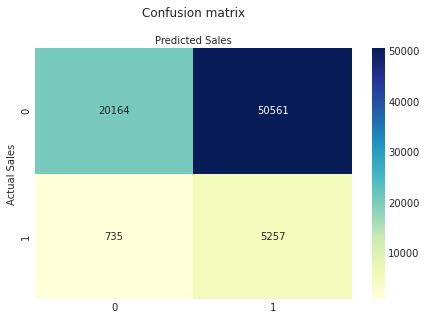

In [ ]:
from xgboost import XGBClassifier
row = results_df.loc[results_df.recall_score >= 0.9].sort_values('precision_score', ascending=False).iloc[0]
# row.max_depth
params = {'colsample_bytree': row.colsample_bytree, 'gamma': row.gamma, 'learning_rate': row.learning_rate, 'max_depth': int(row.max_depth), 'scale_pos_weight': row.scale_pos_weight, 'subsample': row.subsample, 'n_estimators': int(row.n_estimators), 'min_child_weight': int(row.min_child_weight)}

# XGBOOST model with Scaling
xgb_scale_test = XGBClassifier(**params) #scale_pos_weight=18


xgb_scale_test.fit(pd.concat([X_train,X_val[X_train.columns]]),pd.concat([y_train,y_val]))

# Prediction on Val set
scale_xgb_val_test = xgb_scale_test.predict(X_test[X_train.columns])
prob_scale_xgb_val_test = xgb_scale_test.predict_proba(X_test[X_train.columns])

# Confusion matrix on evaluation set
cm = confusion_matrix(y_test, scale_xgb_val_test)
class_names=[0,1] # name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Sales')
plt.xlabel('Predicted Sales')



In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, scale_xgb_val_test))

              precision    recall  f1-score   support

           0       0.96      0.29      0.44     70725
           1       0.09      0.88      0.17      5992

    accuracy                           0.33     76717
   macro avg       0.53      0.58      0.31     76717
weighted avg       0.90      0.33      0.42     76717



In [ ]:
# supresses future warnings 
import warnings                                                 
warnings.simplefilter(action='ignore')

# Import the pandas library for df creation
import pandas as pd

# Import the NumPy library to use the random package
import numpy as np
import math

# Import the matplotlib library for plotting
import matplotlib.pyplot as plt

# set plot style
plt.style.use('seaborn-whitegrid')

# Use the magic function to ensure plots render in a notebook
%matplotlib inline

# Import the seaborn library for plotting
import seaborn as sns

from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

from datetime import datetime

# from shutil import copyfile

import pickle

import shutil

import datetime

from datetime import timedelta

from datetime import datetime

import plotly.express as px

import scipy.stats as ss

import warnings

# from causalnex.structure import StructureModel

warnings.simplefilter(action='ignore')

from pyspark.sql.functions import date_format

# importing XGBOOST Classifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# train validation split of traing data
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn import set_config

import mlflow

from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer

from sklearn.preprocessing import OneHotEncoder

from mlflow.models import infer_signature, signature
from mlflow.tracking import MlflowClient

In [ ]:
with open("/dbfs/FileStore/hj8398/Leads/transformer_model_current_25Nov2023.pickle", 'rb') as f:
  distil_model = pickle.load(f)

In [ ]:
df_lead = pd.read_csv("/dbfs/FileStore/hj8398/Leads/Leads_from_1stJan2023_to_30th_June_2023.csv")

In [ ]:
# Target Variable Encoding
def dep_var(df):

  def tar_var(x):
    if x == "Closed - Sale": 
      return 1
    else:
      return 0
    
  df["CLOSD_STS"] = df["CLOSD_STS"].apply(lambda x: tar_var(x))

  return df

In [ ]:
df_lead = dep_var(df_lead)


In [ ]:
def data_filters(df):
  # Filters for our data
  df = df[df["STS"] == "Closed"]
  df = df[df["RSN_FOR_LEAVING"] == "Sales Opportunity"]
  return df


def date_col_trans(df):
  df["Days_diff"] = (pd.to_datetime(df['EXPIRY_DT']) - pd.to_datetime(df.CREATED_DT)).dt.days
  # df["Days_diff"] = (pd.to_datetime(df['EXPIRY_DT']) - pd.to_datetime(df.CREATED_DT)).apply(lambda x: x.days)
  df['dt_day_of_week'] = (pd.to_datetime(df['CREATED_DT'])).dt.day_of_week
  # df['dt_day_of_week'] = (pd.to_datetime(df['CREATED_DT'])).apply(lambda x: x.day_of_week)


  def days_diff(x):
  
    if x < 0: 
      return 0
    else:
      return x

  df["Days_diff"] = df["Days_diff"].apply(days_diff)
  # df["Days_diff"] = df["Days_diff"].apply(lambda x: days_diff(x))

  return df


def text_trans(df):
  # Calculating the length of text for 1st iteration
  df["text_len"] = df["OTH_NOTE"].str.len()
  # df["text_len"] = df["OTH_NOTE"].apply(lambda x: 0 if type(x)==float else len(x))
  return df


def tf_idf_trans(df, pipeline):

  # with open(pipeline_path, 'rb') as f:
  #   pipeline = pickle.load(f)

  df["clusters"] = -1

  df["clusters"].loc[df['OTH_NOTE'].notna()] = pipeline.predict(model_input=df['OTH_NOTE'].loc[df['OTH_NOTE'].notna()])

  return df


def distilbert_trans(df, pipeline, tokenizer):

  # with open(pipeline_path, 'rb') as f:
  #   pipeline = pickle.load(f)
  class LeadsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

  def compute_preds(model, data_loader, device):
    with torch.no_grad():
        preds = []
        
        for batch_idx, batch in enumerate(data_loader):
        
        ### Prepare data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            # logits = outputs['logits']
            # predicted_labels = torch.argmax(logits, 1)
            # preds += predicted_labels
            # logits = outputs['logits']
            # predicted_labels = torch.argmax(logits, 1)
            preds += outputs['logits']            
        
        return preds
  
  df["distil_preds"] = -1

  df['text'] = df['OTH_NOTE']
  df['labels'] = 0

  train_texts = df["text"].loc[df['text'].notna()].values
  train_labels = df["labels"].loc[df['text'].notna()].values

  train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)

  train_dataset = LeadsDataset(train_encodings, train_labels)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)


  DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # input_ids = train_loader['input_ids'].to(DEVICE)
  # attention_mask = train_loader['attention_mask'].to(DEVICE)
  # labels = train_loader['labels'].to(DEVICE)
  # outputs = model(input_ids, attention_mask=attention_mask)
  # logits = outputs['logits']

  s = pd.Series(compute_preds(pipeline, train_loader, DEVICE))

  def second_term(lst):
    return np.exp(float(lst[1]))

  df["distil_preds"].loc[df['OTH_NOTE'].notna()] = s.apply(second_term)

  

  return df



def cat_to_col_trans(df):
  # Transforming TRANS_TYPE column

  # df['Other_Trans_Type'] = df['TRANS_TYPE'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Other' in x))
  df['TRANS_TYPE'] = df['TRANS_TYPE'].fillna('Other')
  df['Other_Trans_Type'] = 1*df['TRANS_TYPE'].str.contains('Other',na=False)
  # df['Add_a_Line'] = df['TRANS_TYPE'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Add-a-Line' in x))
  df['Add_a_Line'] = 1*df['TRANS_TYPE'].str.contains('Add-a-Line',na=False)
  # df['Upgrade'] = df['TRANS_TYPE'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Upgrade' in x))
  df['Upgrade'] = 1*df['TRANS_TYPE'].str.contains('Upgrade',na=False)
  # df['Rate_Plan_Migration'] = df['TRANS_TYPE'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Rate Plan Migration' in x))
  df['Rate_Plan_Migration'] = 1*df['TRANS_TYPE'].str.contains('Rate_Plan_Migration',na=False)

  # Transforming PRD_DSCSD column

  # df['Wireless'] = df['PRD_DSCSD'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Wireless' in x))
  df['Wireless'] = 1*df['PRD_DSCSD'].str.contains('Wireless',na=False)
  # df['Internet'] = df['PRD_DSCSD'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Internet' in x))
  df['Internet'] = 1*df['PRD_DSCSD'].str.contains('Internet',na=False)
  # df['Video'] = df['PRD_DSCSD'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Video' in x))
  df['Video'] = 1*df['PRD_DSCSD'].str.contains('Video',na=False)


  # Transforming PREF_MTHD_OF_CONTCT column

  # df['In Person'] = df['PREF_MTHD_OF_CONTCT'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('In Person' in x))
  df['In_Person'] = 1*df['PRD_DSCSD'].str.contains('In Person',na=False)
  # df['Email'] = df['PREF_MTHD_OF_CONTCT'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Email' in x))
  df['Email'] = 1*df['PRD_DSCSD'].str.contains('Email',na=False)
  # df['SMS'] = df['PREF_MTHD_OF_CONTCT'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('SMS' in x))
  df['SMS'] = 1*df['PRD_DSCSD'].str.contains('SMS',na=False)
  # df['Call'] = df['PREF_MTHD_OF_CONTCT'].apply(lambda x: 0 if (x is None or type(x)==float) else 1*('Call' in x))
  df['Call'] = 1*df['PRD_DSCSD'].str.contains('Call',na=False)

  return df

def location_trans(df):
  # Preprocessing for Loc_type keeping top 6 values rest as others
    def Loc_type(x):
      if x == "STORE-ARC":
        return "STORE-ARC"
      elif x == "STORE":
        return "STORE"
      elif x == "IN-HOME EXPERTS":
        return "IN-HOME EXPERTS"
      elif x == "VIRTUAL SALES EXP":
        return "VIRTUAL SALES EXP"
      elif x == "MOBILE EVENTS":
        return "MOBILE EVENTS"
      elif x == "KIOSK-ARC":
        return "KIOSK-ARC"
      else :
        return "Other_Loc"

    # df["LOC_TYPE"] = df["LOC_TYPE"].apply(lambda x : Loc_type(x))
    df["LOC_TYPE"] = df["LOC_TYPE"].apply(Loc_type)

    return df
  

def binary_enc_trans(df):

  # RTG preprocess

  def priority(x):
    if x == "Priority":
      return 1
    else :
      return 0
    
  # df["RTG"] = df["RTG"].apply(lambda x: priority(x))
  df["RTG"] = df["RTG"].apply(priority) # Might be the same without using lambda


  # Lead SRC preprocess

  # def Lead_src(x):
  #   if x == "Customer Interaction":
  #     return 0
  #   else :
  #     return 1

  # # df["LEAD_SRC"] = df["LEAD_SRC"].apply(lambda x : Lead_src(x))
  # df["LEAD_SRC"] = df["LEAD_SRC"].apply(Lead_src)

  # CUST_TYPE preprocess

  def Cust_type(x):
    if x == "Existing Customer":
      return 0
    else :
      return 1
    
  # df["CUST_TYPE"] = df["CUST_TYPE"].apply(lambda x : Cust_type(x))
  df["CUST_TYPE"] = df["CUST_TYPE"].apply(Cust_type)

  return df


def impute_trans(df):

  # df["PREV_CARR"] = df[df["CUST_TYPE"] == 0]["PREV_CARR"].fillna("Existing")
  # df["PREV_CARR"].loc[((df["CUST_TYPE"]==0)&(df['PREV_CARR'].isna()))] = "Existing"
  df["PREV_CARR"] = df["PREV_CARR"].fillna("Unknown")
  df["PREV_CARR"].loc[df["PREV_CARR"]==""] = "Unknown"
  # print(df["PREV_CARR"])
  # df["PREV_CARR"] = df["PREV_CARR"].str.replace("nan","Unknown")

  df["SLS_OPRT"] = df["SLS_OPRT"].fillna("Account")
  # df["SLS_OPRT"] = df["SLS_OPRT"].str.replace("","Account")
  df["SLS_OPRT"].loc[df["SLS_OPRT"]==""] = "Account"
  df["SLS_OPRT"] = df["SLS_OPRT"].str.replace("nan","Account")

  df["LOC_TYPE"] = df["LOC_TYPE"].str.replace("","Other_Loc")

  df["NBR_ADDL_LNS"] = df["NBR_ADDL_LNS"].fillna(0)
  df["Days_diff"] = df["Days_diff"].fillna(0)

  return df


def drop_col_trans(df):
  return df.drop(["EXPIRY_DT", "CREATED_DT", "OTH_NOTE", "TRANS_TYPE", "PRD_DSCSD","PREF_MTHD_OF_CONTCT",'text','labels'], axis=1) # "RSN_FOR_LEAVING", "STS", 

ct = ColumnTransformer([('encode_cats', OneHotEncoder(), ["PREV_CARR", "LOC_TYPE", "SLS_OPRT"]),],
                       remainder='passthrough')

def df_format(arr):

  return pd.DataFrame({'Closed_STS':arr})


In [ ]:
class our_XGBoostClassifer(XGBClassifier):
  def __init__(self, **kwargs):
    super().__init__( **kwargs)
  def predict(self, model_input):
    # preds = self.clf.predict(model_input)
    preds = super().predict(model_input)
    prob = super().predict_proba(model_input)
    return pd.DataFrame({'Closed_STS':preds, 'Closed_STS_prob':[itm[1] for itm in prob]})
    # return pd.DataFrame({'Closed_STS':preds})

In [ ]:
text_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
          min_df = 5,
        max_df = 0.95,
        max_features = 8000
        ,stop_words = 'english'
        )
        ),
        ('clf', MiniBatchKMeans(n_clusters=35, init_size=1024, batch_size=2048, random_state=20))
])

# df_lead["clusters"] = -1

# df_lead["clusters"].loc[df_lead['OTH_NOTE'].notna()] = pipeline.fit_predict(df_lead['OTH_NOTE'].loc[df_lead['OTH_NOTE'].notna()])
  
text_pipeline.fit(df_lead['OTH_NOTE'].loc[df_lead['OTH_NOTE'].notna()]) # .loc[df_lead['OTH_NOTE'].notna()

class PipelineWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, pipeline):
        self.pipeline = pipeline

    def predict(self, model_input):
        return self.pipeline.predict(model_input)

# Wrap the encoder
pipeline_wrapped = PipelineWrapper(text_pipeline)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f1db653e1f0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callba

In [ ]:
from transformers import DistilBertTokenizerFast

row = results_df.loc[results_df.recall_score >= 0.9].sort_values('precision_score', ascending=False).iloc[0]
params = {'colsample_bytree': row.colsample_bytree, 'gamma': row.gamma, 'learning_rate': row.learning_rate, 'max_depth': int(row.max_depth), 'scale_pos_weight': row.scale_pos_weight, 'subsample': row.subsample, 'n_estimators': int(row.n_estimators), 'min_child_weight': int(row.min_child_weight)}
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

df_pipeline1 = Pipeline([
    # ('filter_data', FunctionTransformer(data_filters)),
    ('datetime_trans', FunctionTransformer(date_col_trans)), 
    ('text_trans', FunctionTransformer(text_trans)),
    ('cat_to_col_trans', FunctionTransformer(cat_to_col_trans)),
    ('location_trans', FunctionTransformer(location_trans)),
    ('binary_enc_trans', FunctionTransformer(binary_enc_trans)),
    ('impute_trans', FunctionTransformer(impute_trans))
    

    , ('tf_idf_trans', FunctionTransformer(tf_idf_trans, kw_args={'pipeline':pipeline_wrapped}))
    , ('distilbert', FunctionTransformer(distilbert_trans, kw_args={'pipeline':distil_model, 'tokenizer':tokenizer}))
    ,('drop_cols', FunctionTransformer(drop_col_trans)),
    ('preprocessing', ct)
    
    , ('estimator', our_XGBoostClassifer(**params))
  ])

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
userid = 'mz2023'
exp_name = 'Leads_Model_Transformers_MM_eastus2_28Nov2023'

def set_experiment(userid, exp_name):
  try:
    mlflow.create_experiment("/Users/" + userid +"@att.com/" + exp_name)
    mlflow.set_experiment("/Users/" + userid +"@att.com/" + exp_name)
    print('created_EXP')
  except:
    mlflow.set_experiment("/Users/" + userid +"@att.com/" + exp_name)
    print('experiment_already_exists')

In [ ]:
import torch

df_lead = pd.read_csv("/dbfs/FileStore/hj8398/Leads/Leads_from_1stJan2023_to_30th_June_2023.csv")
df_lead = dep_var(df_lead)
df_lead.drop(["LEAD_SRC", "STS", "RSN_FOR_LEAVING"], axis=1, inplace=True)
df_lead_sign = df_lead.drop(["CLOSD_STS"], axis=1)

Y = df_lead["CLOSD_STS"]
X = df_lead.drop(["CLOSD_STS"], axis=1)

# df_pipeline = Pipeline([
# ('fill_data', FunctionTransformer(impute_trans)),
# ('estimator', df_pipeline1)
# ])
model = df_pipeline1.fit(X, Y)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f1db0020820>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [ ]:
import pickle
with open("/dbfs/FileStore/hj8398/Leads/model_w_transformer_current_28Nov2023.pickle", 'wb') as f:
  pickle.dump(model, f)

In [ ]:
# df_lead = pd.read_csv("/dbfs/FileStore/hj8398/Leads/Leads_from_1stJan2023_to_30th_June_2023.csv")
# df_lead = dep_var(df_lead)
with open("/dbfs/FileStore/hj8398/Leads/model_w_transformer_current_28Nov2023.pickle", 'rb') as f:
  model = pickle.load(f)
df_lead.drop(["LEAD_SRC", "STS", "RSN_FOR_LEAVING"], axis=1, inplace=True)
df_test_sign = df_lead.drop(["CLOSD_STS"], axis=1)

Y = df_lead["CLOSD_STS"]
X = df_lead.drop(["CLOSD_STS"], axis=1)

# df_pipeline = Pipeline([
# ('fill_data', FunctionTransformer(impute_trans)),
# ('estimator', df_pipeline1)
# ])
preds = model.predict(X)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f1ec1289b80>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [ ]:
with mlflow.start_run() as run:
    set_experiment(userid, exp_name)
    
    df_lead_sign = df_test_sign
    predictions = preds
    model_signature = infer_signature(df_lead_sign, predictions)
    # model_signature.outputs = mlflow.types.Schema(
    #     [mlflow.types.ColSpec(name="Closed_STS", type=mlflow.types.DataType.float)]
    # )

    model_name = "Leads_Model_Transformers_MM_eastus2_28Nov2023"

    model_log_model = mlflow.sklearn.log_model(model, model_name, signature=model_signature)
    model_version = mlflow.register_model(model_log_model.model_uri, model_name)

experiment_already_exists


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Successfully registered model 'Leads_Model_Transformers_MM_eastus2_28Nov2023'.
2023/11/30 05:40:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Leads_Model_Transformers_MM_eastus2_28Nov2023, version 1
Created version '1' of model 'Leads_Model_Transformers_MM_eastus2_28Nov2023'.


In [ ]:
mlflow_client = MlflowClient()
mlflow_client.transition_model_version_stage(
  name= model_name,
  version= model_version.version,
  stage= "Production"  # Staging or Production
)

Out[27]: <ModelVersion: aliases=[], creation_timestamp=1701322823075, current_stage='Production', description='', last_updated_timestamp=1701322835705, name='Leads_Model_Transformers_MM_eastus2_28Nov2023', run_id='56b1f523c4db44dda406209cab9930e5', run_link='', source='dbfs:/databricks/mlflow-tracking/2497576923098786/56b1f523c4db44dda406209cab9930e5/artifacts/Leads_Model_Transformers_MM_eastus2_28Nov2023', status='READY', status_message='', tags={}, user_id='4897365859746332', version='1'>

In [ ]:
from mlflow.tracking import MlflowClient
client = MlflowClient()
local_dir = "/dbfs/FileStore/hj8398/Leads"

local_path = client.download_artifacts('56b1f523c4db44dda406209cab9930e5', "Leads_Model_Transformers_MM_eastus2_28Nov2023/requirements.txt", local_dir)

In [ ]:
dbutils.fs.cp('dbfs:/FileStore/hj8398/Leads/Leads_Model_Transformers_MM_eastus2_28Nov2023','abfss://ccdleastus2devdlsa@ccdleastus2devstddl.dfs.core.windows.net/ml_models_data/model_artifacts_30Nov2023', recurse=True)

Out[19]: True